In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import pandas as pd
import numpy as np

In [48]:
RUNS_DIR = Path("../results/train_results").resolve()
RUN_NAME = "run_004_four_vp"
run_path = RUNS_DIR / RUN_NAME

print(f"Loading run {run_path}")

Loading run /home/ani/dev/projects/catan-rl/catan-rl/results/train_results/run_004_four_vp


In [49]:
NAME_PREFIX = "Four Victory Point Catan (Tuned)"

# Arguments

In [50]:
arguments_df = pd.read_csv(run_path / "arguments.csv")
arguments_df

,lr,use_linear_lr_decay,eps,gamma,gae_lambda,entropy_coef_start,entropy_coef_final,entropy_coef_start_anneal,entropy_coef_end_anneal,dense_reward_anneal_start,...,update_opponent_policies_every,eval_every,num_eval_episodes,num_eval_processes,load_from_checkpoint,load_file_path,expt_id,update_timeout,max_victory_points,cuda
0,0.0003,True,0.00001,0.999,0.95,0.04,0.005,500,1500,-1,...,1,25,32,32,False,NaN,default,15,4,True


In [51]:
print(arguments_df.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrlrrr}
\toprule
 & lr & use_linear_lr_decay & eps & gamma & gae_lambda & entropy_coef_start & entropy_coef_final & entropy_coef_start_anneal & entropy_coef_end_anneal & dense_reward_anneal_start & dense_reward_anneal_end & value_loss_coef & max_grad_norm & seed & num_processes & num_envs_per_process & num_steps & truncated_seq_len & ppo_epoch & num_mini_batch & clip_param & total_env_steps & recompute_returns & no_cuda & cuda_deterministic & num_policies_to_store & add_policy_every & update_opponent_policies_every & eval_every & num_eval_episodes & num_eval_processes & load_from_checkpoint & load_file_path & expt_id & update_timeout & max_victory_points & cuda \\
\midrule
0 & 0.000300 & True & 0.000010 & 0.999000 & 0.950000 & 0.040000 & 0.005000 & 500 & 1500 & -1 & -1 & 1.000000 & 0.500000 & 101 & 32 & 5 & 30 & 10 & 15 & 16 & 0.200000 & 1000000000.000000 & True & False & False & 500 & 4 & 1 & 25 & 32 & 32 & False & NaN & default & 15 & 4

# Robust Train

In [52]:
train_df = pd.read_csv(run_path / "train.csv")
train_df

,num_games_complete,update_num,val_loss,action_loss,entropy_loss,total_policy_steps,total_elapsed_time,curr_entropy_coef,curr_reward_weight
0,5,1,0.006733,-0.024827,0.110155,9600,0.029524,NaN,NaN
1,40,2,0.007219,-0.031567,0.108854,14400,0.057045,NaN,NaN
2,101,3,0.008756,-0.035434,0.108387,19200,0.083948,NaN,NaN
3,161,4,0.008790,-0.035651,0.115172,24000,0.110799,NaN,NaN
4,209,5,0.009140,-0.033409,0.101682,28800,0.138309,NaN,NaN
...,...,...,...,...,...,...,...,...,...
796,42698,797,0.012722,-0.040200,0.094376,3830400,21.988379,0.029640,NaN
797,42752,798,0.008018,-0.046717,0.096150,3835200,22.015060,0.029605,NaN
798,42804,799,0.018224,-0.042436,0.091701,3840000,22.041890,0.029570,NaN
799,42865,800,0.016638,-0.043883,0.087538,3844800,22.069125,0.029535,NaN


In [53]:
def plot_losses(train_df, filename, title, color_palette, split_subgraphs=False, add_correlation=False, context="paper"):
    """
    Plots the training losses (validation loss, action loss, entropy loss) either in
    a single graph or as split subgraphs, with an option to add correlation lines.
    
    Parameters:
        train_df (pd.DataFrame): DataFrame containing the losses and update numbers.
        split_subgraphs (bool): If True, plots each loss on a separate subplot.
        add_correlation (bool): If True, adds a correlation line to each plot.
    """
    sns.set_theme(style="white", palette=color_palette, context=context)
    
    if split_subgraphs:
        fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
        fig.suptitle(title, fontsize=18)
        
        loss_columns = ["val_loss", "action_loss", "entropy_loss"]
        titles = ["Validation Loss Over Updates", "Action Loss Over Updates", "Entropy Loss Over Updates"]
        y_labels = ["Validation Loss", "Action Loss", "Entropy Loss"]
        
        for i, (col, title, ylabel) in enumerate(zip(loss_columns, titles, y_labels)):
            sns.lineplot(data=train_df, x="update_num", y=col, ax=axes[i], label=col.replace('_', ' ').title())
            axes[i].set_title(title, fontsize=14)
            axes[i].set_ylabel(ylabel, fontsize=12)
            axes[i].grid(True)
            
            if add_correlation:
                z = np.polyfit(train_df["update_num"], train_df[col], 1)
                p = np.poly1d(z)
                axes[i].plot(train_df["update_num"], p(train_df["update_num"]), linestyle="--", color="gray")
        
        axes[-1].set_xlabel("Policy Update Number", fontsize=12)
        plt.tight_layout(rect=[0.00, 0.00, 0.99, 0.95])
    
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        sns.lineplot(data=train_df, x="update_num", y="val_loss", label="Validation Loss", ax=ax)
        sns.lineplot(data=train_df, x="update_num", y="action_loss", label="Action Loss", ax=ax)
        sns.lineplot(data=train_df, x="update_num", y="entropy_loss", label="Entropy Loss", ax=ax)
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Update Number", fontsize=14)
        ax.set_ylabel("Loss", fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True)
        
        if add_correlation:
            for col in ["val_loss", "action_loss", "entropy_loss"]:
                z = np.polyfit(train_df["update_num"], train_df[col], 1)
                p = np.poly1d(z)
                ax.plot(train_df["update_num"], p(train_df["update_num"]), linestyle="--", label=f"{col.replace('_', ' ').title()} Trend", color="black")
        
        plt.tight_layout()

    plt.savefig(filename)
    plt.show()

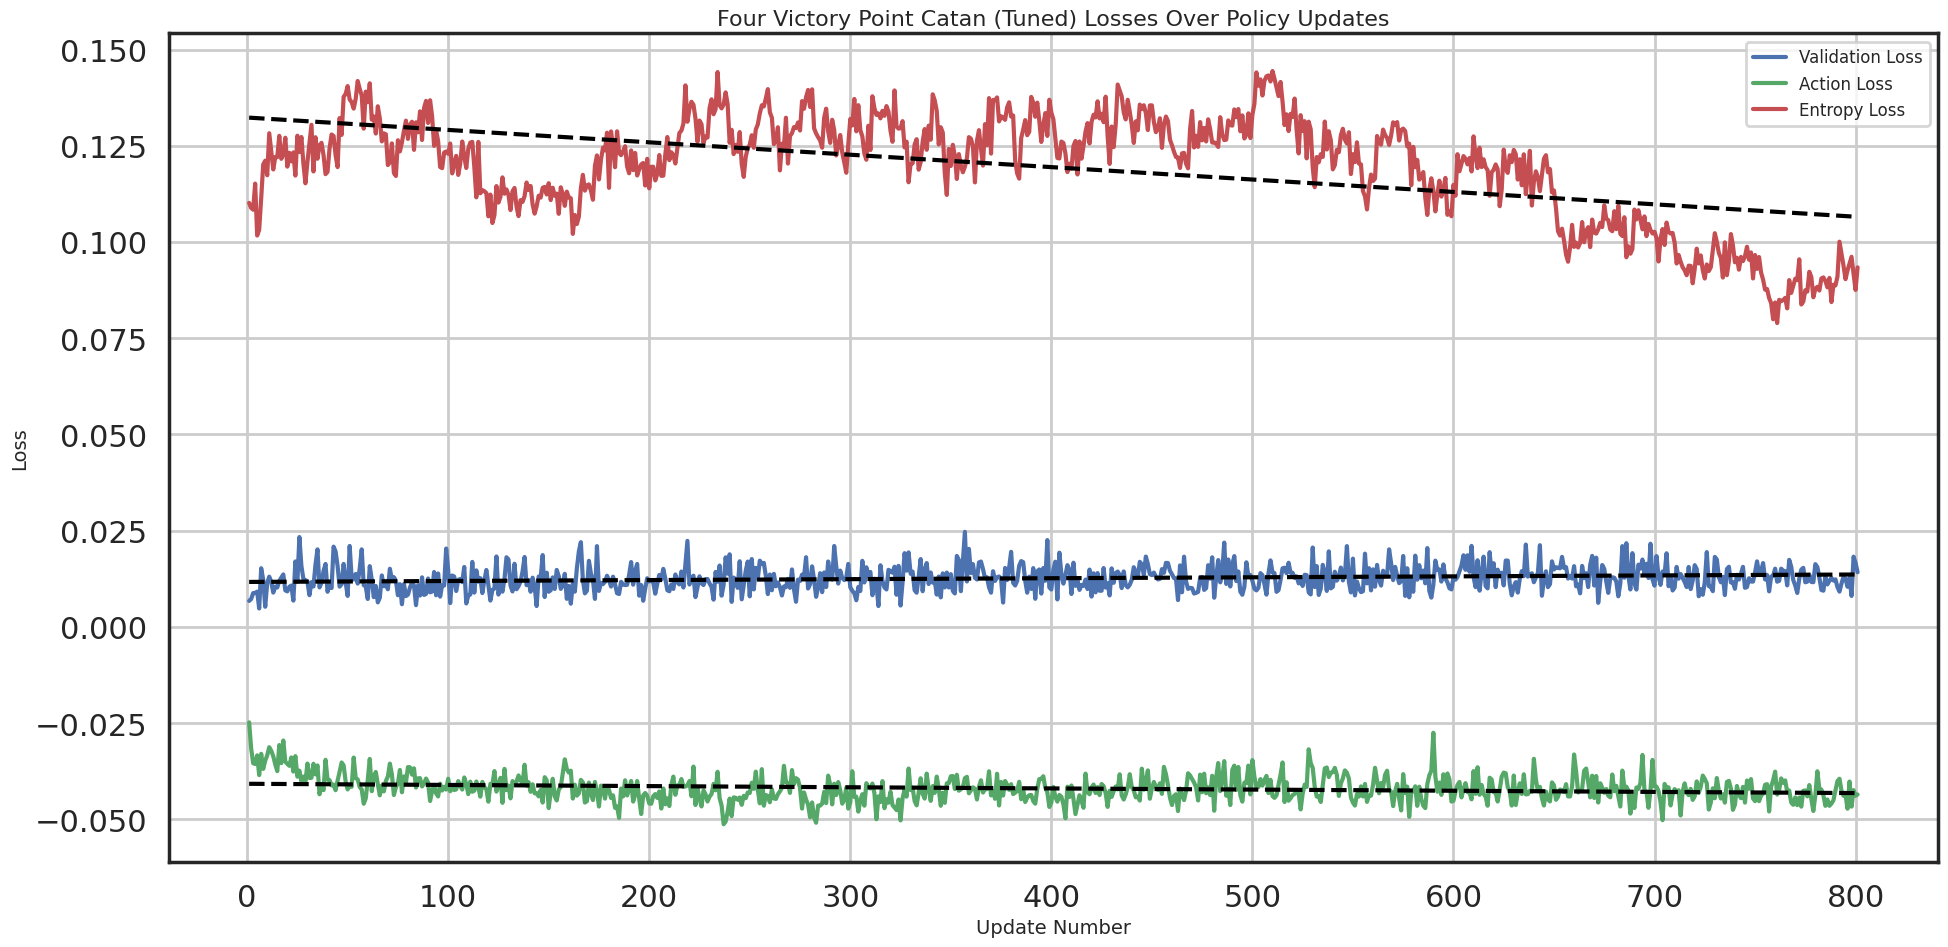

In [54]:
plot_losses(train_df, run_path / "train_loss_graph_poster.png", f"{NAME_PREFIX} Losses Over Policy Updates", sns.color_palette("deep6"), split_subgraphs=False, add_correlation=True, context="poster")

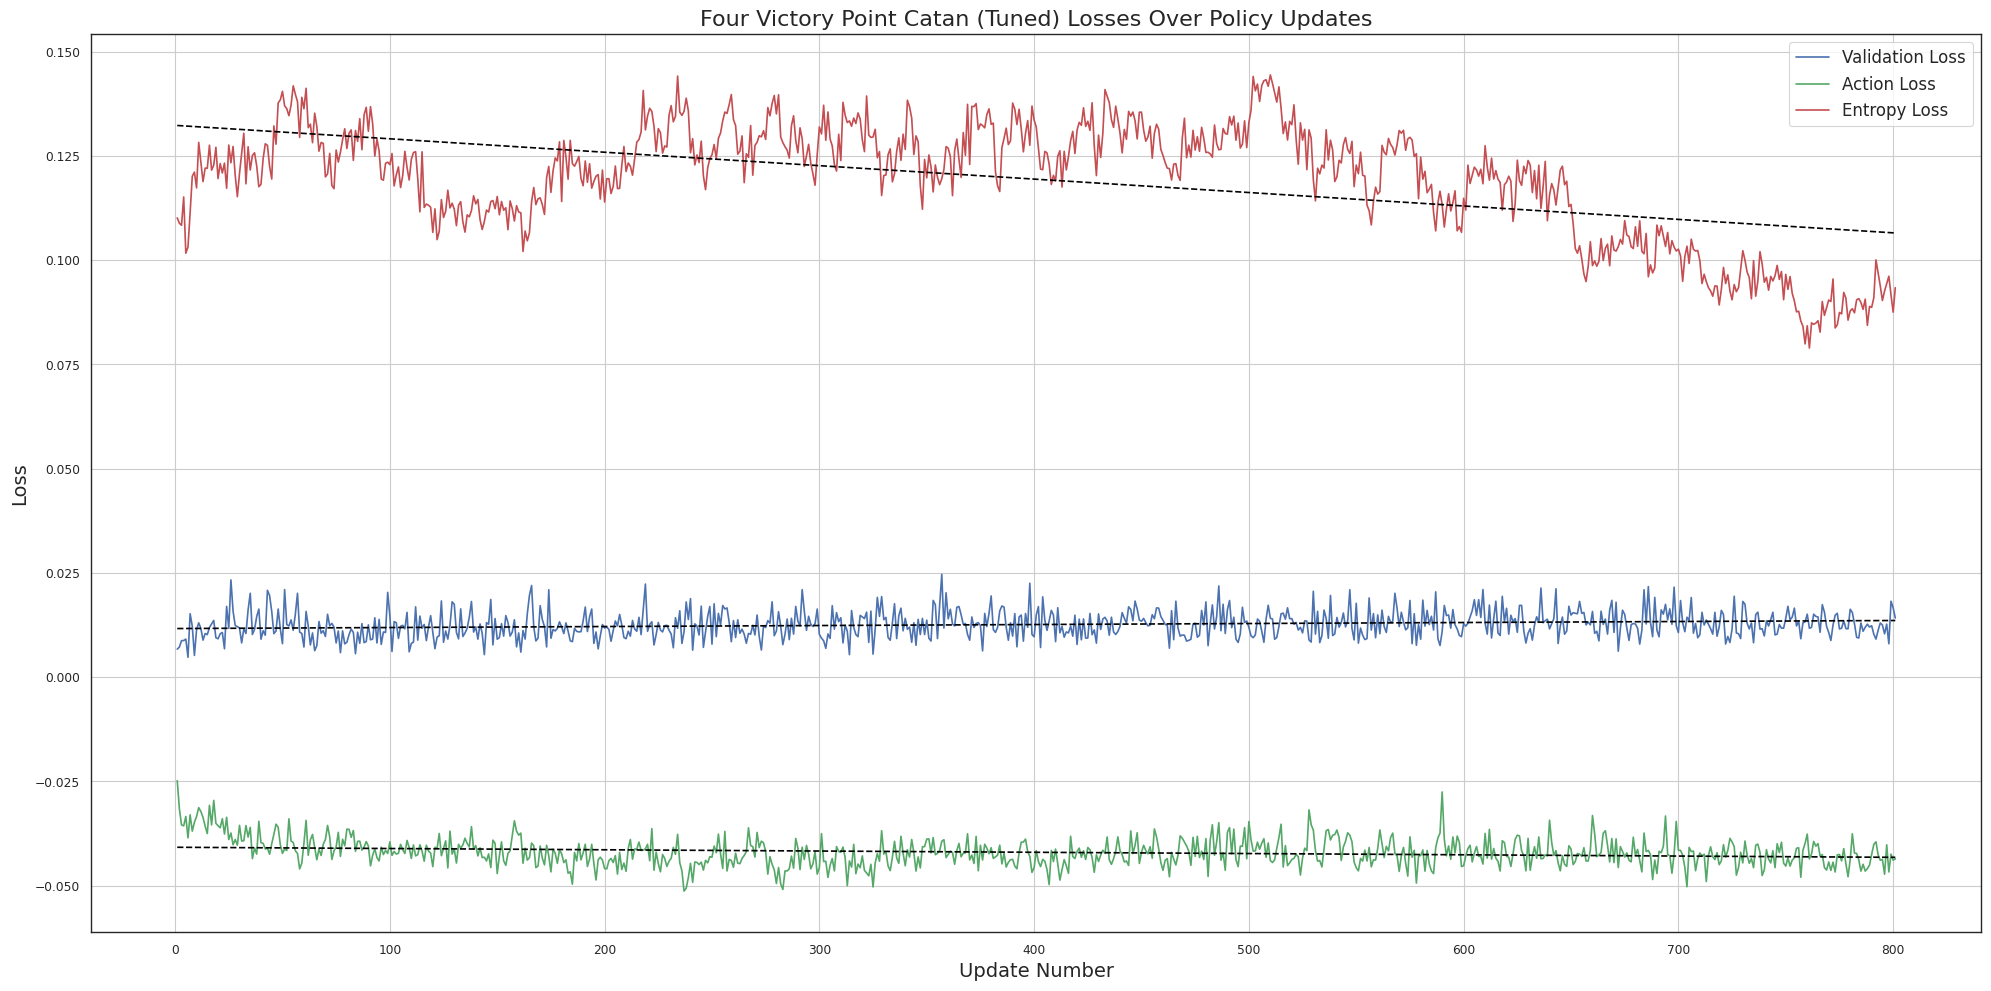

In [55]:
plot_losses(train_df, run_path / "train_loss_graph_paper.png", f"{NAME_PREFIX} Losses Over Policy Updates", sns.color_palette("deep6"), split_subgraphs=False, add_correlation=True, context="paper")

In [56]:
# plot_losses(train_df, run_path / "train_loss_graph_gray.png", "gray", split_subgraphs=True, add_correlation=True)

# Evals

In [57]:
eval_df = pd.read_csv(run_path / "eval.csv")
eval_df

,update_num,opponent_policy_id,num_eval_episodes,policy_win_frac,avg_game_length,avg_num_policy_decisions,avg_victory_points
0,25,random,32,0.007812,323.59375,85.50000,2.65625
1,50,random,32,0.008789,378.18750,102.06250,2.78125
2,75,random,32,0.005859,271.87500,70.75000,2.50000
3,100,random,32,0.011719,364.46875,94.18750,2.81250
4,100,25 updates ago,32,0.011719,397.56250,102.40625,3.15625
...,...,...,...,...,...,...,...
98,775,100 updates ago,32,0.006836,381.21875,93.96875,2.59375
99,800,random,32,0.010742,319.06250,80.50000,3.03125
100,800,25 updates ago,32,0.009766,311.78125,76.53125,2.71875
101,800,50 updates ago,32,0.007812,352.31250,81.93750,2.59375


In [58]:
def plot_eval_hists(eval_df, filename, title, color_palette, bins=10, context="paper", normalize=False):
    """
    Plots the evaluation metrics (policy win fraction, average game length, average number
    of policy decisions, average victory points) in a 2x2 grid format with histograms.
    
    Parameters:
        eval_df (pd.DataFrame): DataFrame containing the evaluation metrics.
        filename (str): Filepath to save the plot.
        title (str): Title of the entire figure.
        color_palette (list or str): Seaborn color palette for the plots.
        bins (int): Number of bins for the histograms.
        context (str): Context for the Seaborn theme (e.g., "paper", "notebook").
        normalize (bool): If True, normalize the y-axis to show density instead of frequency.
    """
    sns.set_theme(style="white", context=context, palette=color_palette)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=18)

    # Define metrics and corresponding titles/labels
    metrics = [
        ("policy_win_frac", "Distribution of Policy Win Fraction", "Policy Win Fraction", "Probability" if normalize else "Frequency"),
        ("avg_game_length", "Distribution of Average Game Length", "Average Game Length", "Probability" if normalize else "Frequency"),
        ("avg_num_policy_decisions", "Distribution of Average Number of Decisions Per Game", "Average Number of Policy Decisions", "Probability" if normalize else "Frequency"),
        ("avg_victory_points", "Distribution of Average Victory Points Per Game", "Average Victory Points", "Probability" if normalize else "Frequency"),
    ]

    use_colors = color_palette != "gray"
    if use_colors:
        colors = sns.color_palette(color_palette, len(metrics))

    for i, (metric, metric_title, x_label, y_label) in enumerate(metrics):
        row, col = divmod(i, 2)  # Determine position in 2x2 grid
        if use_colors:
            sns.histplot(
                eval_df[metric],
                bins=bins,
                kde=True,
                ax=axes[row, col],
                stat="probability" if normalize else "count",
                color=colors[i]
            )
        else:
            sns.histplot(
                eval_df[metric],
                bins=bins,
                kde=True,
                ax=axes[row, col],
                stat="probability" if normalize else "count",
            )
        axes[row, col].set_title(metric_title, fontsize=14)
        axes[row, col].set_xlabel(x_label, fontsize=12)
        axes[row, col].set_ylabel(y_label, fontsize=12)

    plt.tight_layout(rect=[0.00, 0.00, 0.99, 0.95])
    plt.savefig(filename)
    plt.show()

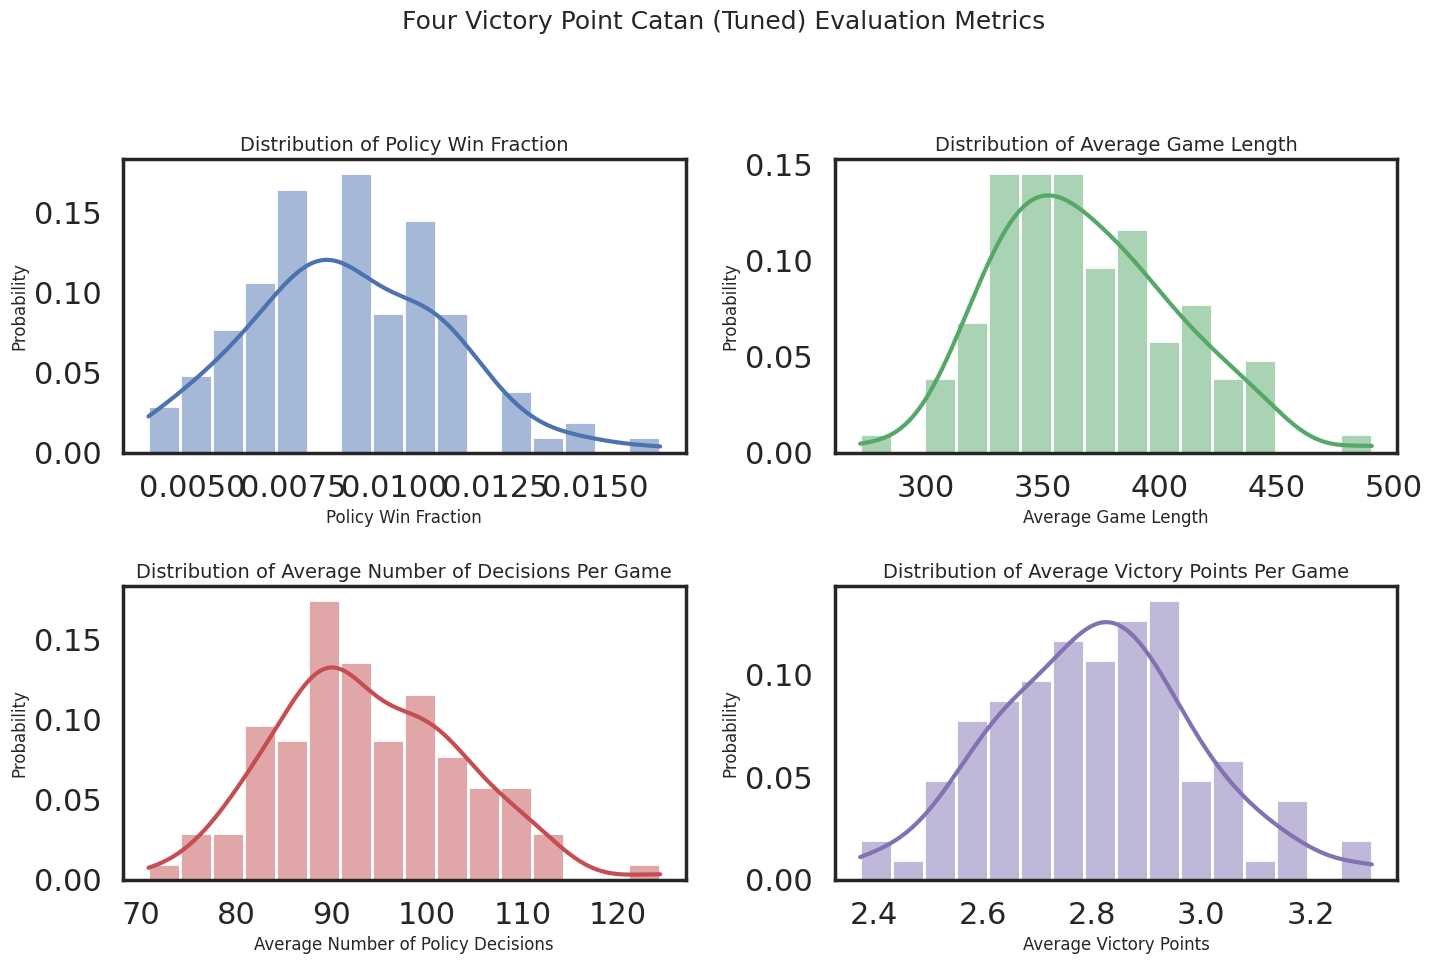

In [59]:
plot_eval_hists(eval_df, run_path / "eval_metrics_hist_poster.png", f"{NAME_PREFIX} Evaluation Metrics", sns.color_palette("deep6"), bins=16, context="poster", normalize=True)

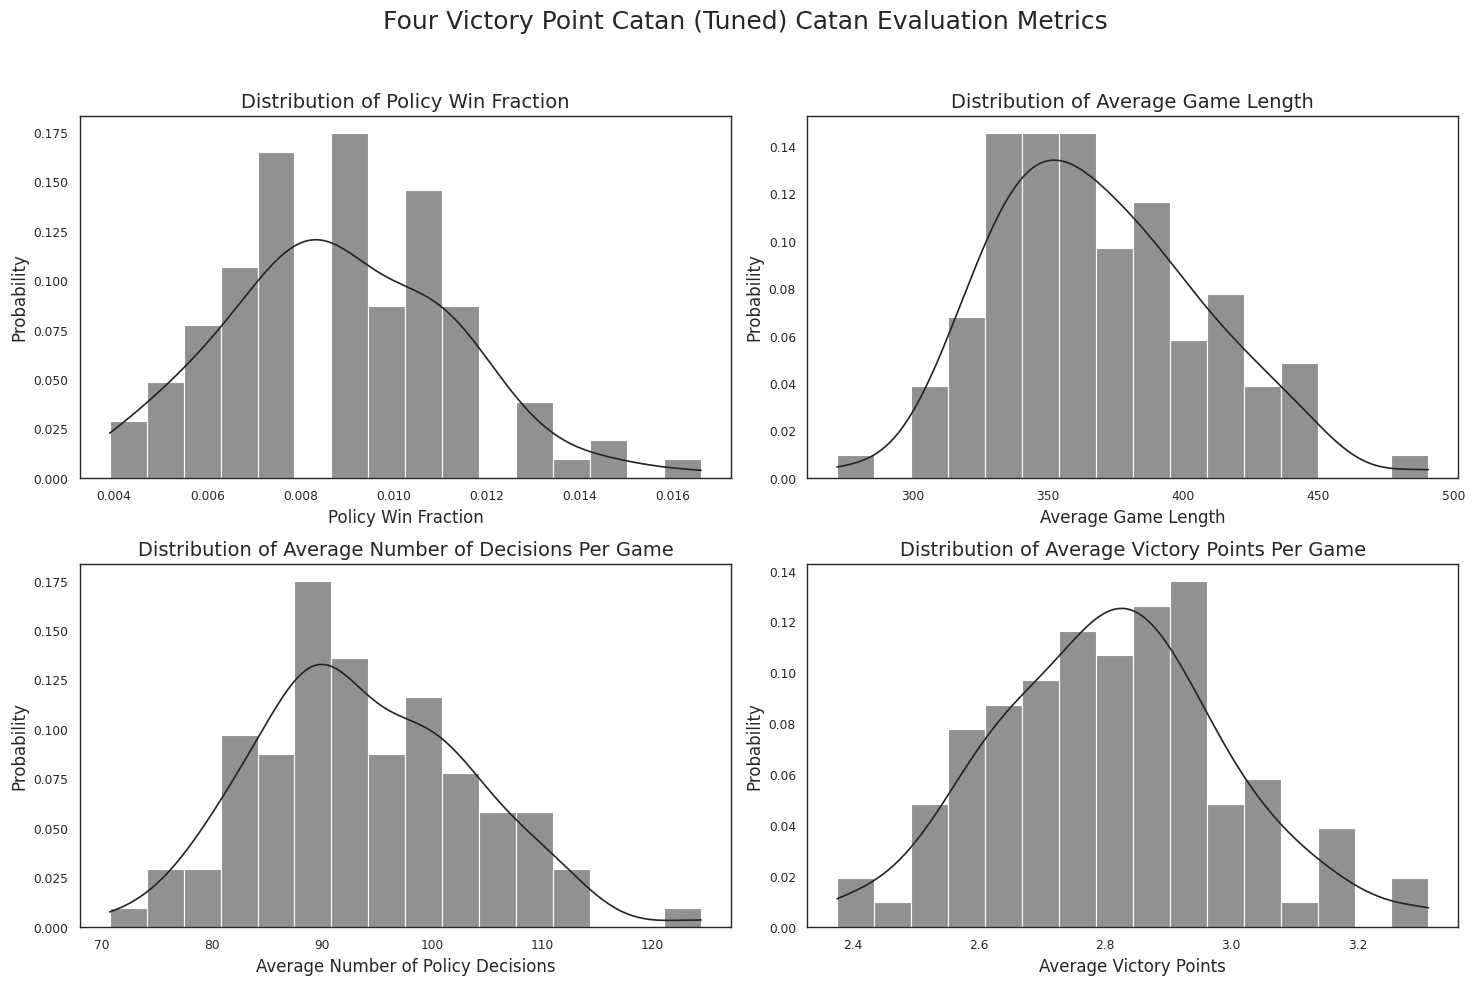

In [60]:
plot_eval_hists(eval_df, run_path / "eval_metrics_hist_paper.png", f"{NAME_PREFIX} Catan Evaluation Metrics", "gray", bins=16, context="paper", normalize=True)

In [61]:
def plot_avg_eval_over_updates(eval_df, filename, title, color_palette, add_correlation_line=False, context="paper"):
    """
    Plots evaluation metrics (average game length, average number of decisions,
    policy win fraction, average victory points) in a single column with optional correlation lines.
    
    Parameters:
        eval_df (pd.DataFrame): DataFrame containing the evaluation metrics.
        filename (str): Filepath to save the plot.
        title (str): Title of the entire figure.
        color_palette (list or str): Seaborn color palette for the plots.
        add_correlation_line (bool): If True, adds correlation lines to the plots.
        context (str): Context for the Seaborn theme (e.g., "paper", "notebook").
    """
    sns.set_theme(style="white", palette=color_palette, context=context)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=True)
    fig.suptitle(title, fontsize=18)
    
    # Define metrics and corresponding titles/labels
    metrics = [
        ("avg_game_length", "Average Game Length Over Updates", "Average Game Length (# of actions)"),
        ("avg_num_policy_decisions", "Average Number of Decisions Per Game Over Updates", "Average Number of Decisions"),
        ("policy_win_frac", "Policy Win Fraction Over Updates", "Policy Win Fraction"),
        ("avg_victory_points", "Average Victory Points Over Updates", "Average Victory Points"),
    ]
    
    for i, (metric, metric_title, ylabel) in enumerate(metrics):
        sns.lineplot(data=eval_df, x="update_num", y=metric, ax=axes[i], marker="o")
        axes[i].set_title(metric_title, fontsize=16)
        axes[i].set_ylabel(ylabel, fontsize=14)
        axes[i].grid(True)
        
        if add_correlation_line:
            z = np.polyfit(eval_df["update_num"], eval_df[metric], 1)
            p = np.poly1d(z)
            axes[i].plot(eval_df["update_num"], p(eval_df["update_num"]), linestyle="--", color="gray")

    axes[-1].set_xlabel("Update Number", fontsize=14)
    plt.tight_layout(rect=[0.00, 0.00, 0.99, 0.95])
    plt.savefig(filename)
    plt.show()

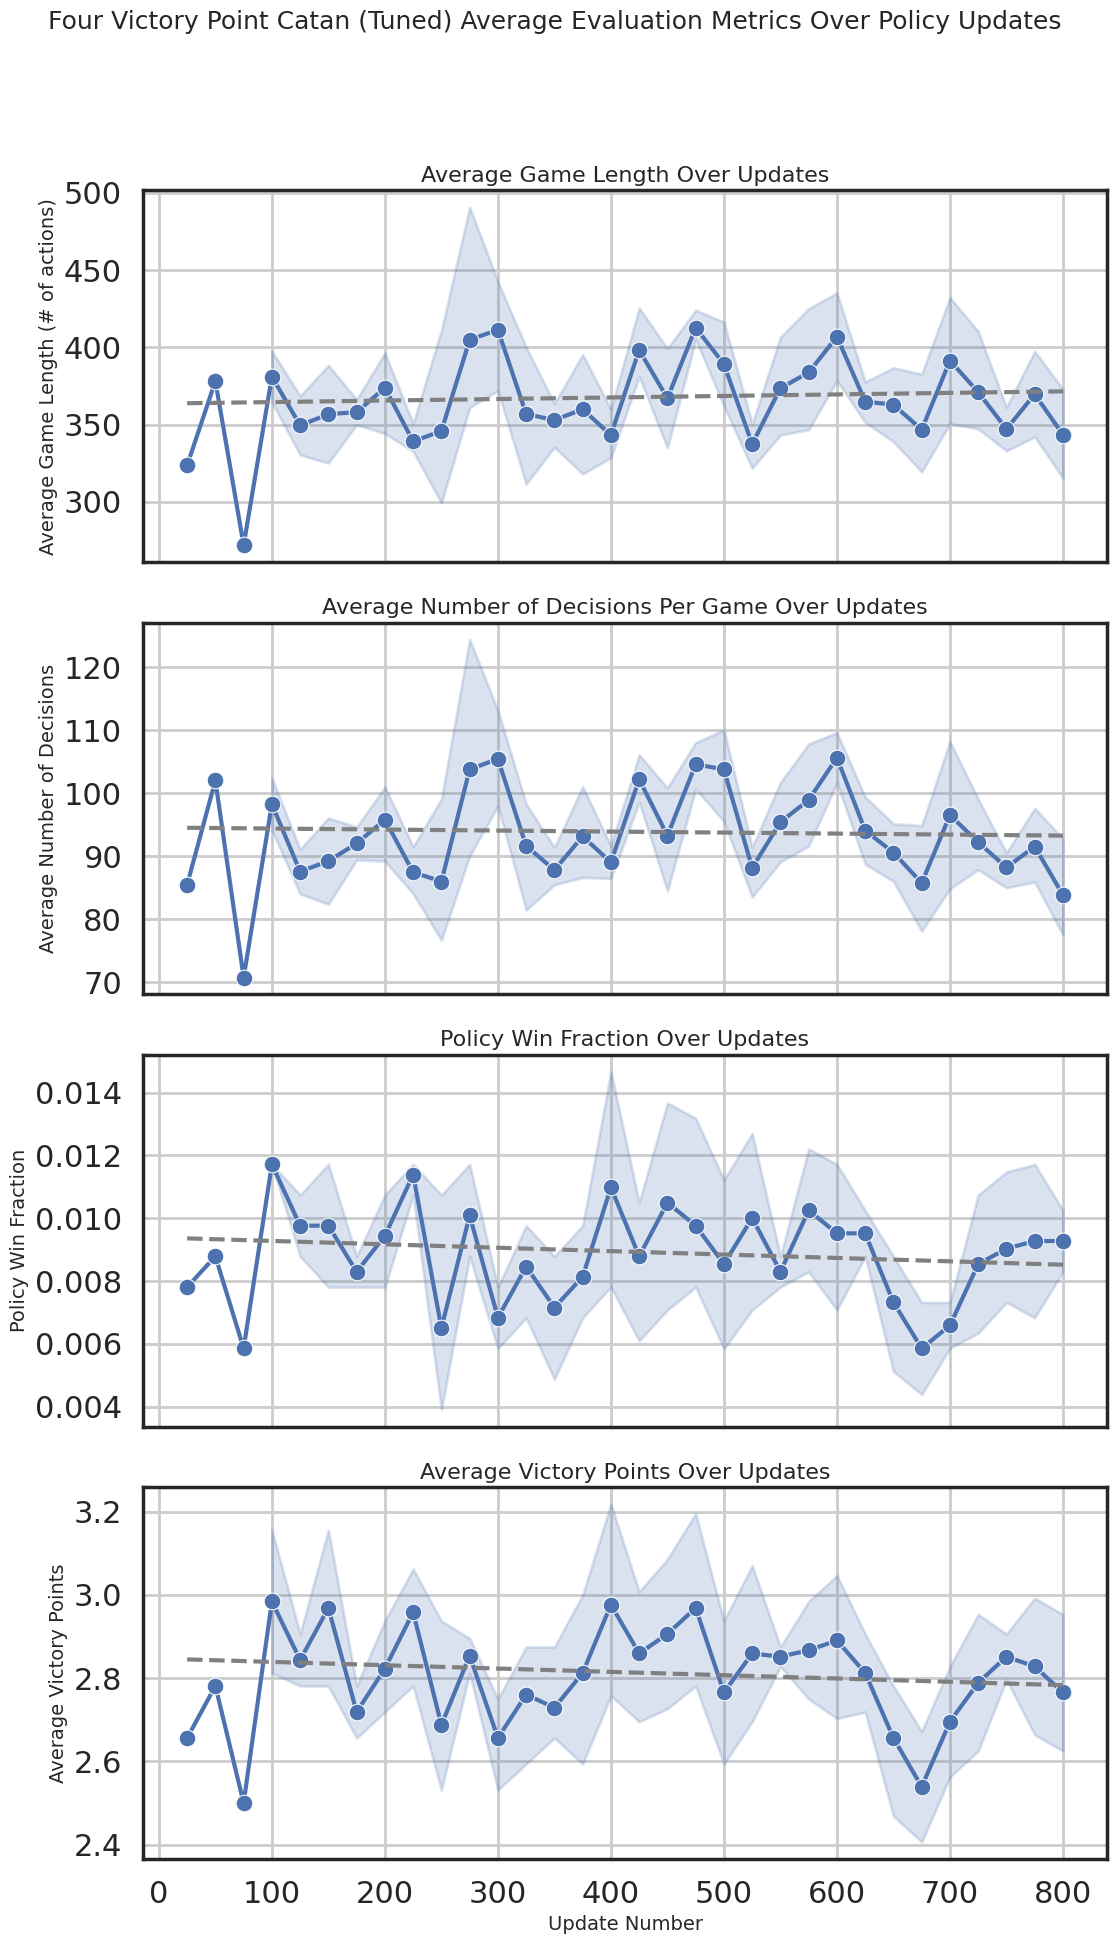

In [62]:
plot_avg_eval_over_updates(eval_df, run_path / "avg_eval_metrics_over_updates_poster.png", f"{NAME_PREFIX} Average Evaluation Metrics Over Policy Updates", sns.color_palette("deep6"), add_correlation_line=True, context="poster")

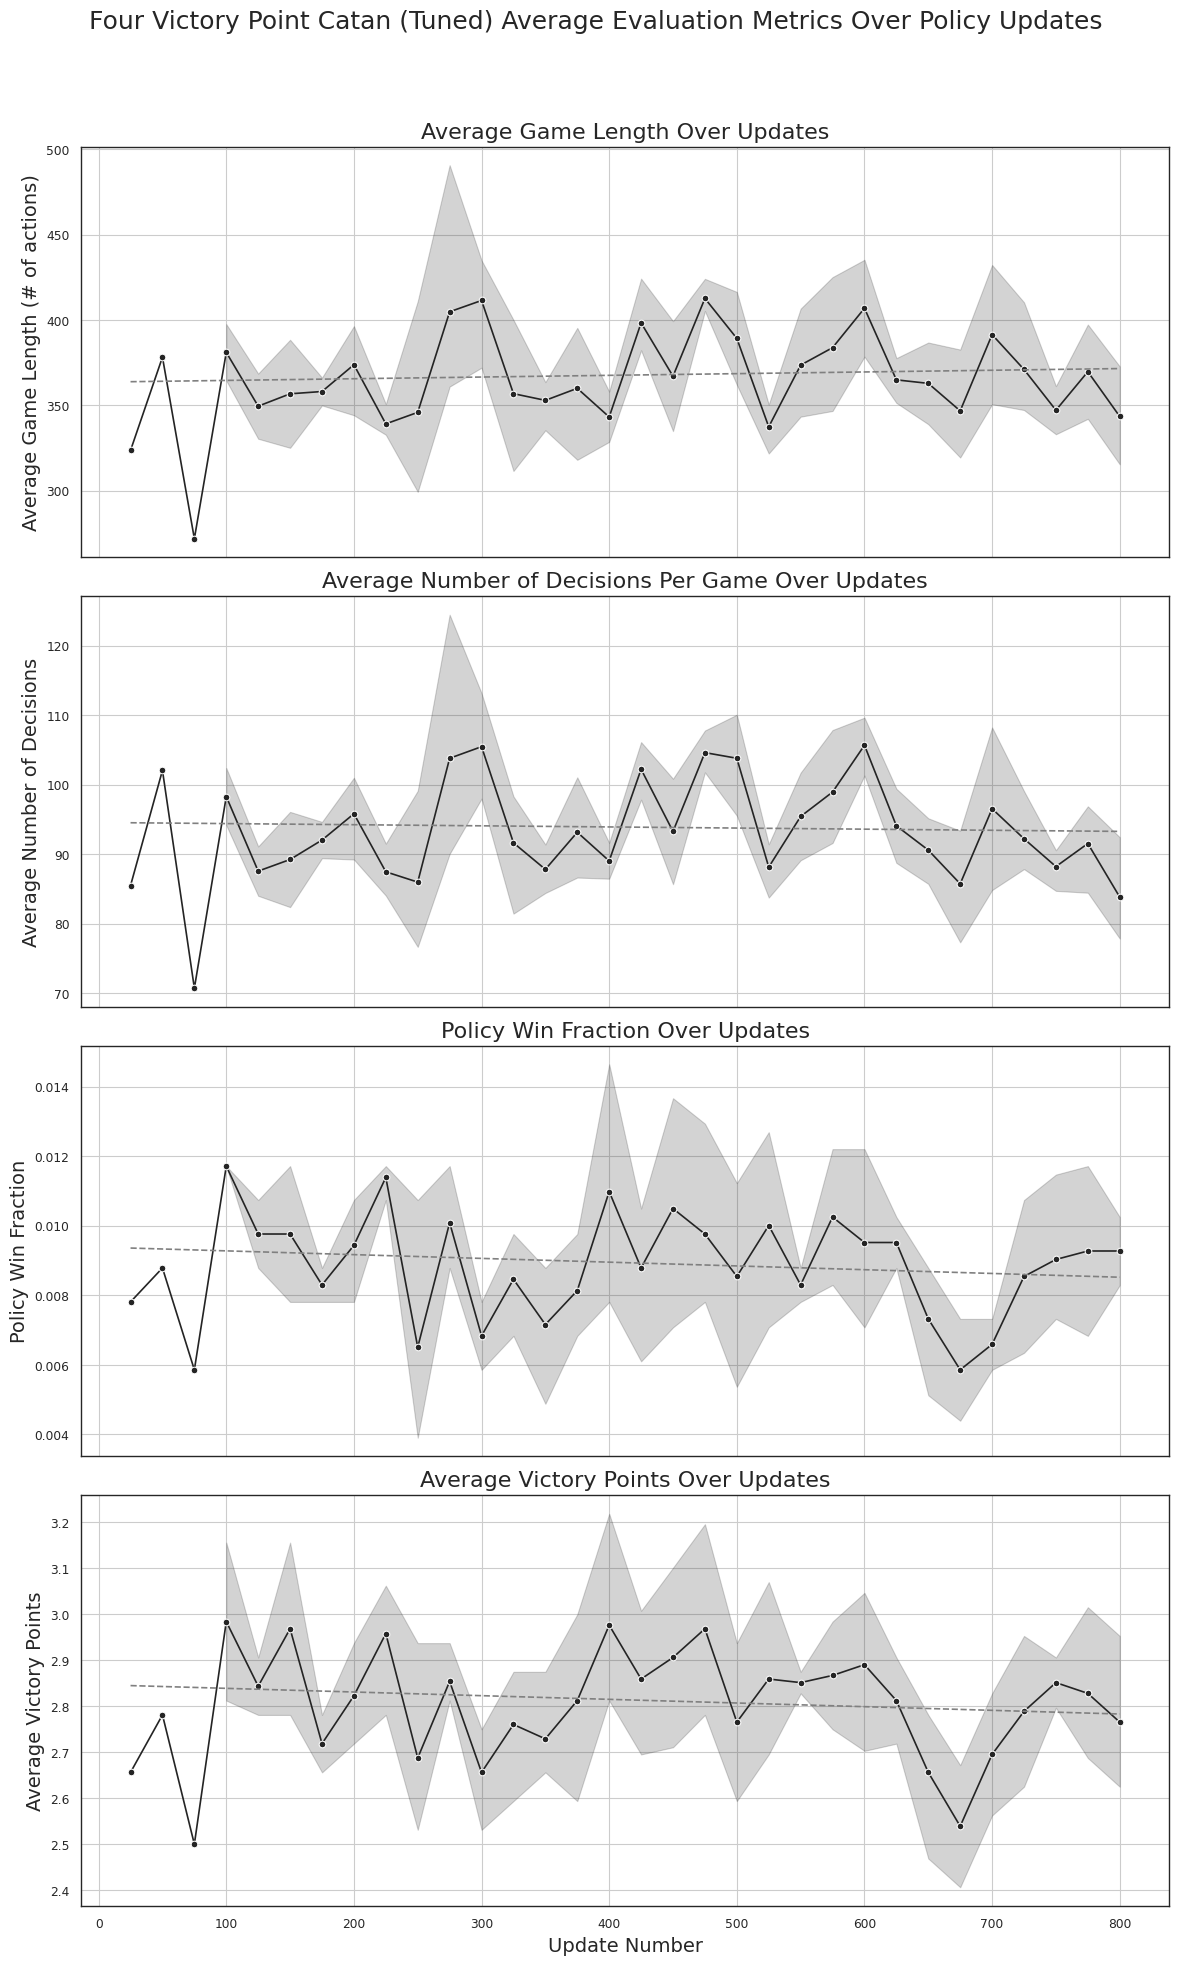

In [63]:
plot_avg_eval_over_updates(eval_df, run_path / "avg_eval_metrics_over_updates_paper.png", f"{NAME_PREFIX} Average Evaluation Metrics Over Policy Updates", "gray", add_correlation_line=True, context="paper")

In [64]:
def plot_eval_policies_grid(eval_df, filename, title, color_palette, context="notebook"):
    """
    Plots evaluation metrics (average game length, average number of decisions,
    policy win fraction, average victory points) using a FacetGrid layout,
    with opponent_policy_id as the columns and metrics as the rows.

    Parameters:
        eval_df (pd.DataFrame): DataFrame containing the evaluation metrics.
        filename (str): Filepath to save the plot.
        title (str): Title of the entire figure.
        color_palette (list or str): Seaborn color palette for the plots.
        context (str): Context for the Seaborn theme (e.g., "paper", "notebook").
    """
    sns.set_theme(style="whitegrid", palette=color_palette, context=context)

    # Melt the DataFrame to have metrics as a single column
    metrics = ["avg_game_length", "avg_num_policy_decisions", "policy_win_frac", "avg_victory_points"]
    melted_df = eval_df.melt(
        id_vars=["update_num", "opponent_policy_id"],
        value_vars=metrics,
        var_name="Metric",
        value_name="Value"
    )

    # Create a FacetGrid
    g = sns.FacetGrid(
        melted_df,
        row="Metric",
        col="opponent_policy_id",
        hue="Metric" if color_palette != "gray" else None,
        margin_titles=False,
        sharex=True,
        sharey=False,
        height=4,
        aspect=1.5
    )

    # Map a lineplot to each subplot
    g.map(sns.regplot, "update_num", "Value")

    # def custom_titles(row, col):
    #     metric_map = {
    #         "avg_game_length": "Average Game Length Over Updates",
    #         "avg_num_policy_decisions": "Average Number of Decisions Per Game Over Updates",
    #         "policy_win_frac": "Policy Win Fraction Over Updates",
    #         "avg_victory_points": "Average Victory Points Over Updates",
    #     }
    #     metric_title = metric_map.get(row, row)
    #     return f"{metric_title}\nOpponent Policy: {col}"

    # for ax, (row, col) in zip(g.axes.flat, melted_df.groupby(["Metric", "opponent_policy_id"]).groups):
    #     metric, policy = row, col
    #     ax.set_title(custom_titles(metric, policy), fontsize=12)

    col_titles = {
        "random": "Random Policy",
        "25 updates ago": "25 Updates Ago",
        "50 updates ago": "50 Updates Ago",
        "100 updates ago": "100 Updates Ago",
    }

    row_titles = {
        "avg_game_length": "Average Game Length",
        "avg_num_policy_decisions": "Average Number of Decisions",
        "policy_win_frac": "Policy Win Fraction",
        "avg_victory_points": "Average Victory Points",
    }

    # Apply column titles
    g.set_titles(col_template="{col_name}")
    for ax, col_val in zip(g.axes[0], g.col_names):
        ax.set_title(col_titles.get(col_val, col_val), fontsize=14, weight="bold")

    # Apply row titles
    for ax, row_val in zip(g.axes[:, 0], g.row_names):
        ax.annotate(
            row_titles.get(row_val, row_val),
            xy=(-0.1, 0.5),
            xycoords="axes fraction",
            fontsize=14,
            weight="bold",
            ha="right",
            va="center",
            rotation=90,
        )
        ax.yaxis.label.set_visible(False)

    # g.set_axis_labels("Update Number", "", fontsize=14, weight="bold")
    g.set_axis_labels("", "")
    g.figure.text(0.5, 0.00, "Update Number", ha="center", fontsize=14, weight="bold")

    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(title, fontsize=18, weight="bold")

    # Save and show the plot
    plt.savefig(filename)
    plt.show()


In [65]:
print("use the same version for poster and paper")
# plot_eval_policies_grid(eval_df, run_path / "eval_metrics_policies_grid_poster.png", "Ten Victory Point Catan Evaluation Metrics by Opponent Policy", sns.color_palette("deep6"), context="poster")

use the same version for poster and paper


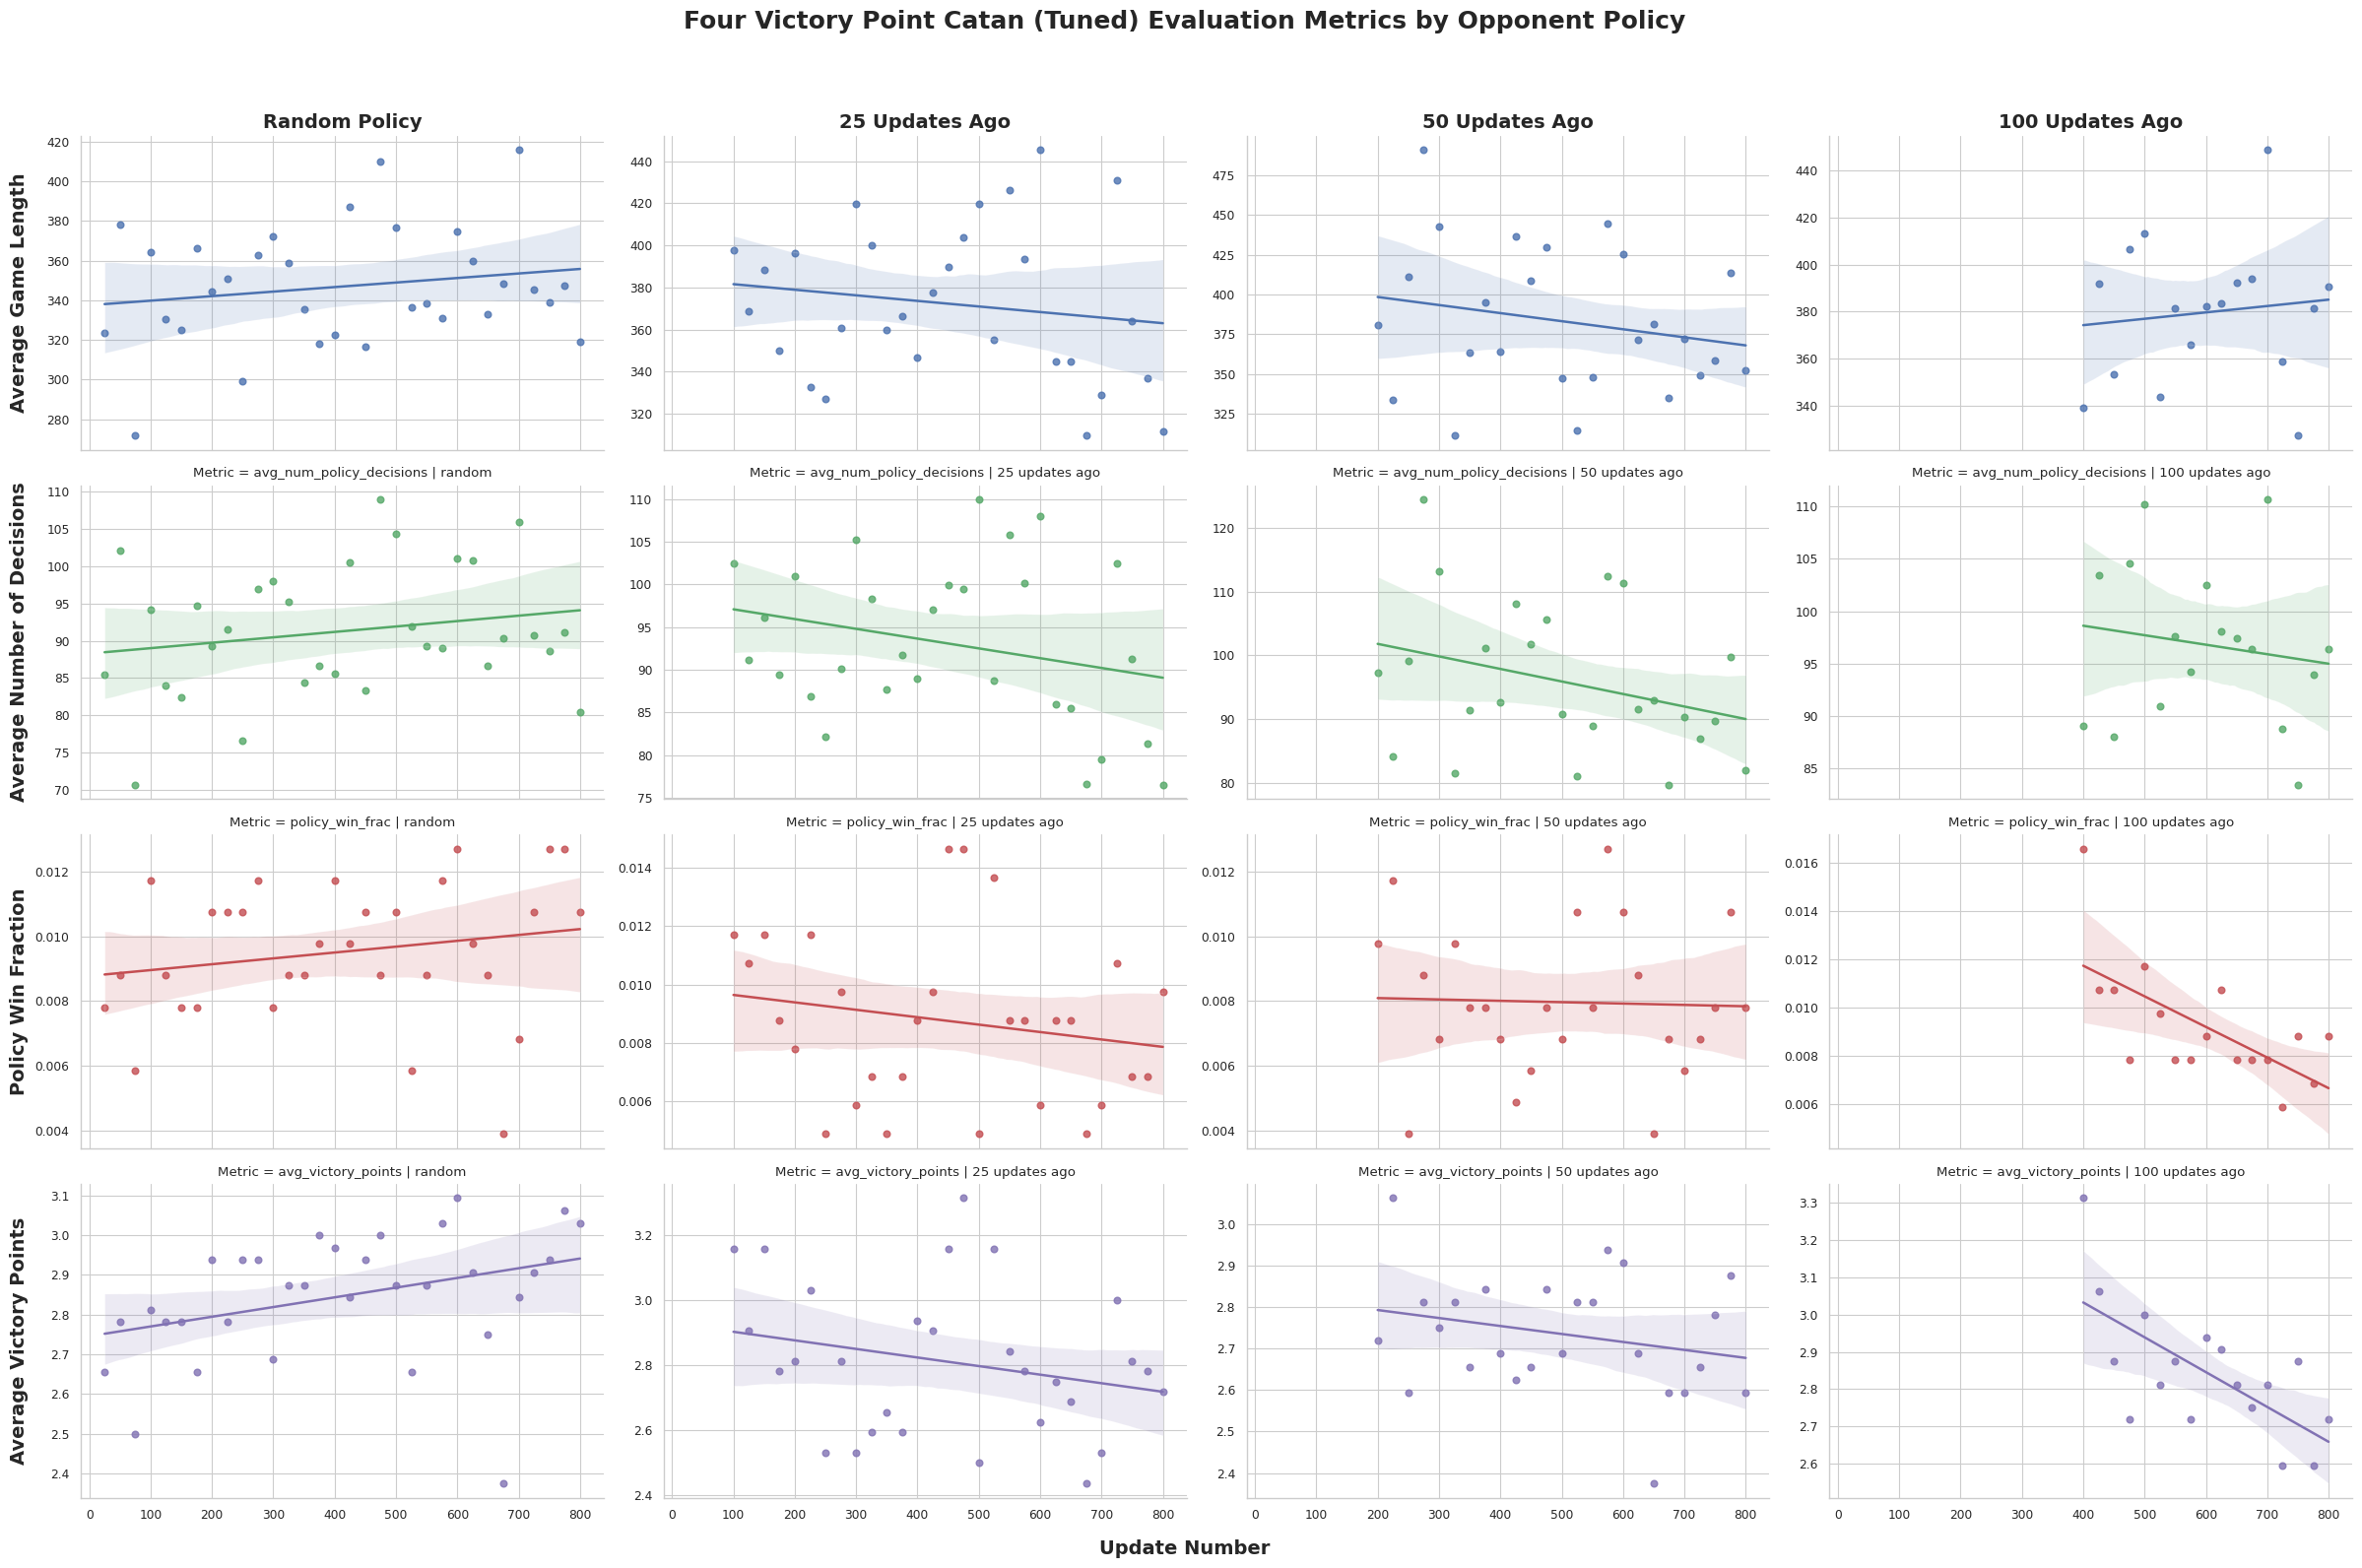

In [66]:
plot_eval_policies_grid(eval_df, run_path / "eval_metrics_policies_grid_paper.png", f"{NAME_PREFIX} Evaluation Metrics by Opponent Policy", sns.color_palette("deep6"), context="paper")